In [136]:
import numpy as np
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder as lab
from sklearn.metrics import accuracy_score as ac
import re
import random
from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn import metrics
import lightgbm as lgb
sns.set(color_codes=True)
sns.set_palette(sns.color_palette("bright"))
from sklearn.preprocessing import binarize, LabelEncoder, MinMaxScaler

In [137]:
train=pd.read_csv('trainms.csv')
test=pd.read_csv('testms.csv')
df=train
df.index=range(len(df))
df=df.drop(columns=['s.no','Timestamp'])
submission=pd.read_csv('./samplems.csv')

In [138]:
%%javascript
IPython.OutputArea.auto_scroll_threshold = 9999;

<IPython.core.display.Javascript object>

# Understanding the data

["Don't know" 'Risk'] [938  62]


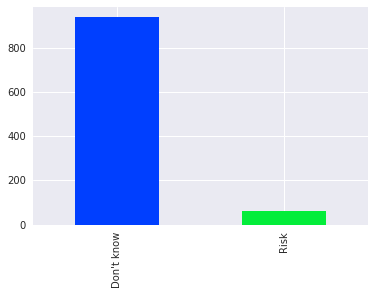

In [139]:
# COMMENTS HANDLE

commentRegex =  r"^.*(?:Neurological|drugs|issues|mental health|depression|disorder).*$"
a=np.array(df.comments)
for i in range(len(a)):
    if not pd.isnull(a[i]):
        m=re.search(commentRegex,a[i])
        if m!=None:
            a[i]="Risk"
        else:
            a[i]="Don't know"
    else:
        a[i]="Don't know"
df["comments"]=a
a,b = np.unique(df["comments"],return_counts=True)
print(a,b)
df.head(5)
df["comments"].value_counts().plot(kind="bar")

# too many comments are not given/ empty, too hard to infer --> drop the feature

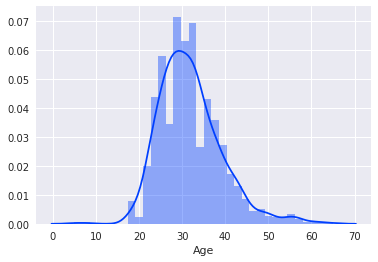

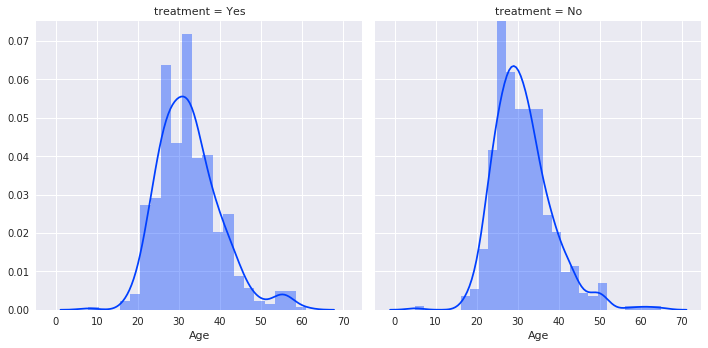

In [140]:
# AGE HANDLE

# ORIGINAL DATA
# [[-1726, 1], [-29, 1], [-1, 1], [5, 1], [8, 1], [11, 1], [18, 7], [19, 9], [20, 6], [21, 16], [22, 21], [23, 51], [24, 46], [25, 61], [26, 75], [27, 71], [28, 68], [29, 85], [30, 63], [31, 67], [32, 82], [33, 70], [34, 65], [35, 55], [36, 37], [37, 43], [38, 39], [39, 34], [40, 33], [41, 21], [42, 20], [43, 28], [44, 11], [45, 12], [46, 12], [47, 2], [48, 6], [49, 4], [50, 6], [51, 5], [53, 1], [54, 3], [55, 3], [56, 4], [57, 3], [58, 1], [60, 2], [61, 1], [62, 1], [65, 1], [72, 1], [329, 1]]

#a,b=np.unique(df.Age,return_counts=True)
#print([([a[i],b[i]]) for i in range(len(a))])

# HANDLING -- replace ages >100 and <0 with median

a = np.array(df.Age)
b = np.array(df.Age)
b = np.array([x for x in b if x>=0 and x<=100])
age_median = np.median(b)
for i in range(len(a)):
    if a[i]>100 or a[i]<0:
        a[i] = age_median
df["Age"] = a
# df.head(5)
sns.distplot(df["Age"]);
g = sns.FacetGrid(df, col='treatment', size=5)
g = g.map(sns.distplot, "Age")


[['F', 181], ['M', 778], ['T', 41]]


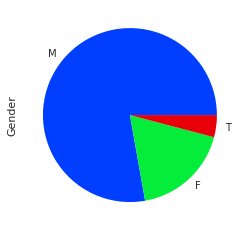

In [141]:
# GENDER HANDLE

# ORIGINAL DATA
# [['A little about you', 1], ['Agender', 1], ['Androgyne', 1], ['Cis Female', 1], ['Cis Male', 2], ['Cis Man', 1], ['Enby', 1], ['F', 38], ['Femake', 1], ['Female', 121], ['Female ', 2], ['Female (cis)', 1], ['Female (trans)', 2], ['Genderqueer', 1], ['Guy (-ish) ^_^', 1], ['M', 116], ['Mail', 1], ['Make', 4], ['Mal', 1], ['Male', 615], ['Male ', 4], ['Male-ish', 1], ['Malr', 1], ['Man', 2], ['Nah', 1], ['Neuter', 1], ['Trans woman', 1], ['Trans-female', 1], ['Woman', 3], ['cis male', 1], ['cis-female/femme', 1], ['f', 16], ['femail', 1], ['female', 63], ['fluid', 1], ['m', 34], ['maile', 1], ['male', 206], ['male leaning androgynous', 1], ['msle', 1], ['non-binary', 1], ['ostensibly male, unsure what that really means', 1], ['p', 1], ['queer', 1], ['something kinda male?', 1], ['woman', 1]]
#a,b=np.unique(df.Gender,return_counts=True)
#print([([a[i],b[i]]) for i in range(len(a))])

# HANDLING -- M-> male F-> female (contains male/female), All other cases - Transgender
a = np.array(df.Gender)
regex = r"^(?:m|M|male|Male|f|F|female|Female)$"
mreg = r"^(?:m|M|male|Male)$"
freg = r"^(?:f|F|female|Female)$"
for i in range(len(a)):
    m = re.search(regex,a[i])
    if m!=None:
        m1 = re.search(mreg,a[i])
        if m1!=None:
            a[i]="M"
        else:
            a[i]="F"
    else:
        a[i]="T"
df["Gender"]=a
a,b=np.unique(df.Gender,return_counts=True)
print([([a[i],b[i]]) for i in range(len(a))])
df["Gender"].value_counts().plot(kind="pie")
#df.loc[df.Gender=='F','treatment'].value_counts().plot(kind='pie')

123 859 18


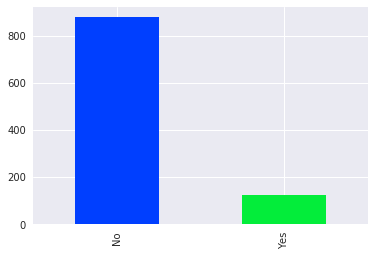

In [142]:
# SELF EMPLOYED HANDLE

# ORIGINAL DATA
a = np.array(df.self_employed)
nYes = (a == "Yes").sum()
nNo = (a == "No").sum()
nNaN = (pd.isnull(a)).sum()
print(nYes,nNo,nNaN)
    
# handling
for i in range(len(a)):
    if pd.isnull(a[i]):
        '''c=np.random.randint(low=1, high=100)
        if(c<88):
            a[i]="Yes"
        else:
            a[i]="No"'''
        a[i]="No"
df["self_employed"]=a
#df.head(5)
df["self_employed"].value_counts().plot(kind="bar")

# handling NaN's

In [143]:
# STATE HANDLE

# ORIGINAL DATA
a = np.array(df.state)
c = np.array(df.Country)
b = [x for x in a if not(pd.isnull(x))]
s = "Out"
nNaN = (pd.isnull(a)).sum()
# print(nNaN)
    
# handling -- 515 nans --> make random states 
stateList = {}
for i in range(len(a)):
    if not pd.isnull(a[i]):
        if c[i] in stateList.keys():
            if a[i] not in stateList[c[i]]:
                stateList[c[i]].append(a[i])
        else:
            stateList[c[i]]=[a[i]]
print(stateList)
for i in range(len(a)):
    if pd.isnull(a[i]) and c[i] in stateList.keys():
        a[i]=random.choice(stateList[c[i]])
    elif pd.isnull(a[i]):
        a[i]=s

df["state"] = a
df.head(5)

{'United States': ['IL', 'IN', 'TX', 'TN', 'MI', 'OH', 'CA', 'CT', 'MD', 'NY', 'NC', 'MA', 'IA', 'PA', 'WA', 'WI', 'UT', 'NM', 'OR', 'FL', 'MN', 'MO', 'AZ', 'CO', 'GA', 'DC', 'NE', 'WV', 'OK', 'KS', 'VA', 'NH', 'KY', 'AL', 'NV', 'NJ', 'SC', 'VT', 'SD', 'ID', 'MS', 'RI', 'WY', 'LA', 'ME'], 'Latvia': ['NY'], 'Israel': ['MD'], 'Bahamas, The': ['IL']}


,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,37,F,United States,IL,No,No,Yes,Often,6-25,No,...,Somewhat easy,No,No,Some of them,Yes,No,Maybe,Yes,No,Don't know
1,44,M,United States,IN,No,No,No,Rarely,More than 1000,No,...,Don't know,Maybe,No,No,No,No,No,Don't know,No,Don't know
2,32,M,Canada,Out,No,No,No,Rarely,6-25,No,...,Somewhat difficult,No,No,Yes,Yes,Yes,Yes,No,No,Don't know
3,31,M,United Kingdom,Out,No,Yes,Yes,Often,26-100,No,...,Somewhat difficult,Yes,Yes,Some of them,No,Maybe,Maybe,No,Yes,Don't know
4,31,M,United States,TX,No,No,No,Never,100-500,Yes,...,Don't know,No,No,Some of them,Yes,Yes,Yes,Don't know,No,Don't know


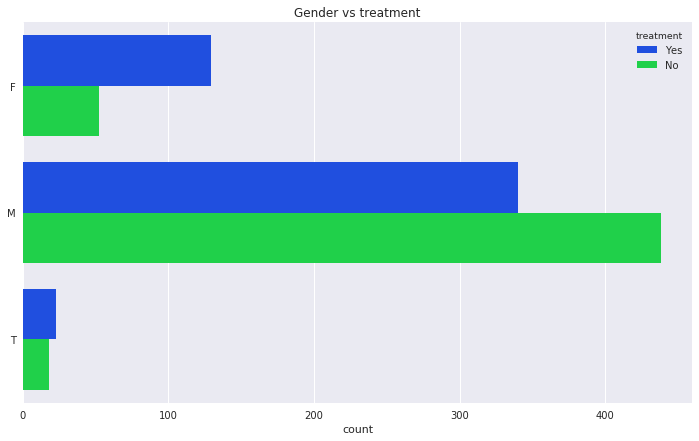

In [144]:
plt.figure(figsize=(12,7))
sns.countplot(y="Gender", hue="treatment", data=df)
plt.title("Gender vs treatment",fontsize=12)
plt.ylabel("")
plt.show()

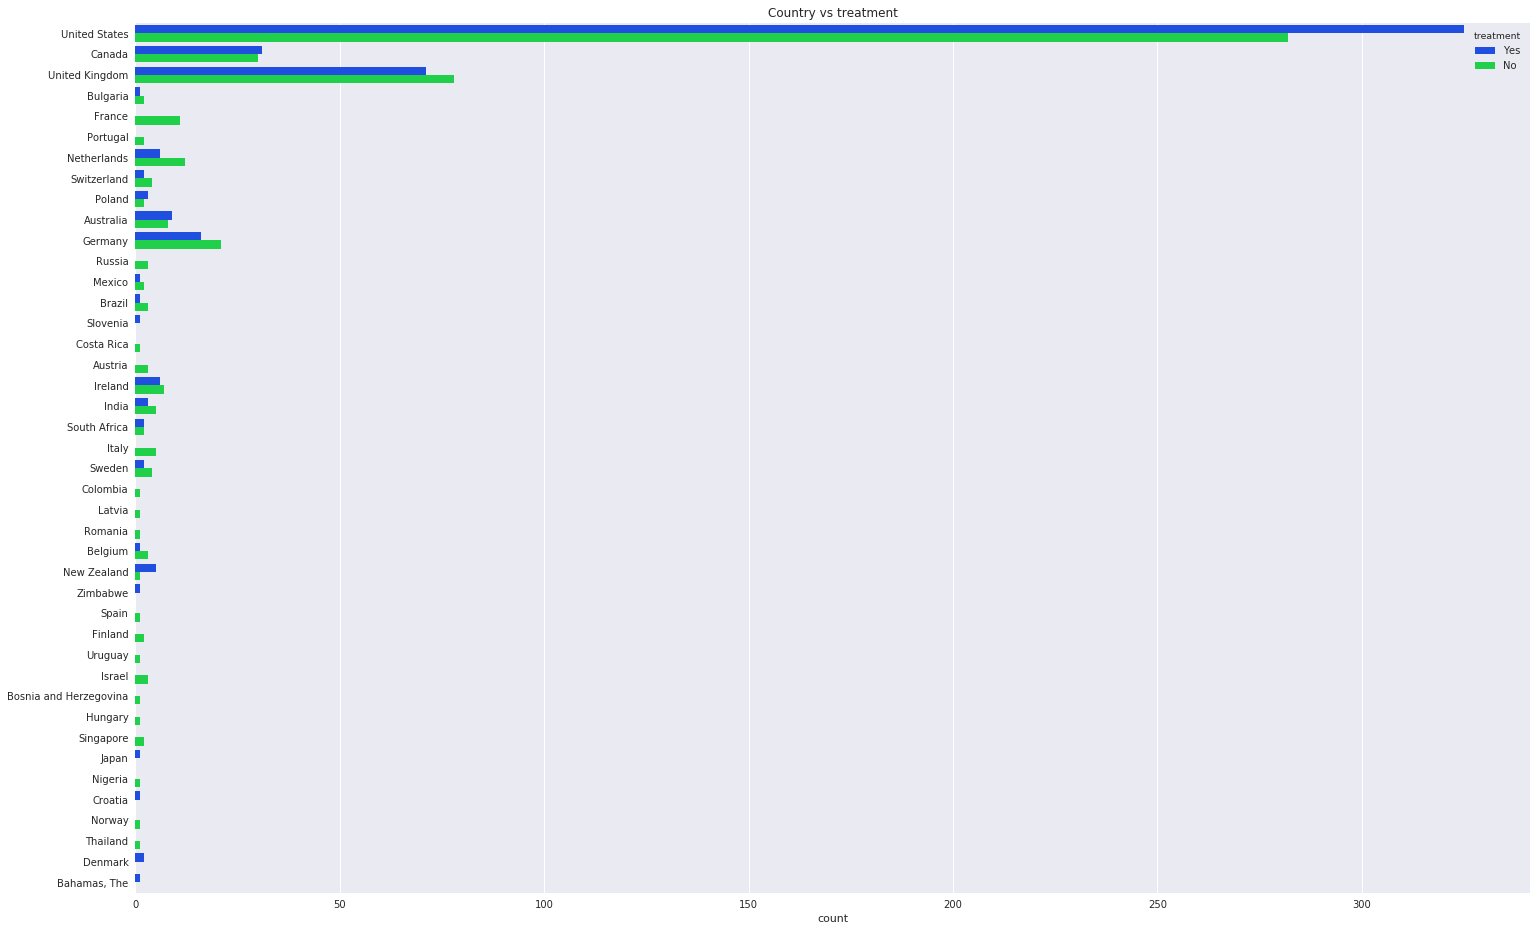

In [145]:
plt.figure(figsize=(25,16))
sns.countplot(y="Country", hue="treatment", data=df)
plt.title("Country vs treatment",fontsize=12)
plt.ylabel("")
plt.show()

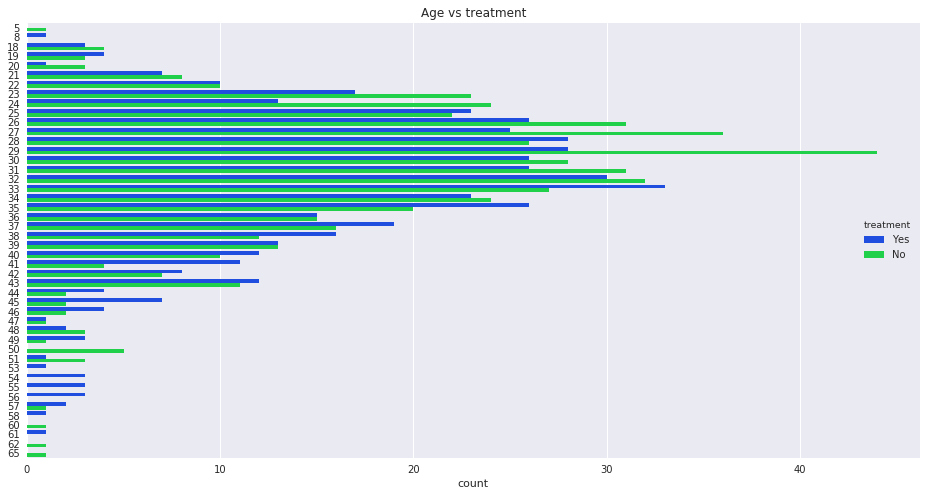

In [146]:
plt.figure(figsize=(16,8))
sns.countplot(y="Age", hue="treatment", data=df)
plt.title("Age vs treatment",fontsize=12)
plt.ylabel("")
plt.show()

In [147]:
# LABEL ENCODING

'''for i in ['Gender','Country','state','self_employed','family_history', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']:
#     print(df[i].unique())
        a=pd.get_dummies(df[i])
        for j in a.columns[:-1]:
            df[i+j]=a[j]
        df=df.drop(columns=[i])'''
encode = {}
for feature in df:
    le = preprocessing.LabelEncoder()
    le.fit_transform(df[feature].astype(str)) 
    le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
    df[feature] = le.fit_transform(df[feature].astype(str))
    labelKey = feature
    labelValue = [*le_name_mapping]
    encode[labelKey] =labelValue
for key, value in encode.items():     
    print(key, value)
df.head()

Age ['18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '46', '47', '48', '49', '5', '50', '51', '53', '54', '55', '56', '57', '58', '60', '61', '62', '65', '8']
Gender ['F', 'M', 'T']
Country ['Australia', 'Austria', 'Bahamas, The', 'Belgium', 'Bosnia and Herzegovina', 'Brazil', 'Bulgaria', 'Canada', 'Colombia', 'Costa Rica', 'Croatia', 'Denmark', 'Finland', 'France', 'Germany', 'Hungary', 'India', 'Ireland', 'Israel', 'Italy', 'Japan', 'Latvia', 'Mexico', 'Netherlands', 'New Zealand', 'Nigeria', 'Norway', 'Poland', 'Portugal', 'Romania', 'Russia', 'Singapore', 'Slovenia', 'South Africa', 'Spain', 'Sweden', 'Switzerland', 'Thailand', 'United Kingdom', 'United States', 'Uruguay', 'Zimbabwe']
state ['AL', 'AZ', 'CA', 'CO', 'CT', 'DC', 'FL', 'GA', 'IA', 'ID', 'IL', 'IN', 'KS', 'KY', 'LA', 'MA', 'MD', 'ME', 'MI', 'MN', 'MO', 'MS', 'NC', 'NE', 'NH', 'NJ', 'NM', 'NV', 'NY', '

,Age,Gender,Country,state,self_employed,family_history,treatment,work_interfere,no_employees,remote_work,...,leave,mental_health_consequence,phys_health_consequence,coworkers,supervisor,mental_health_interview,phys_health_interview,mental_vs_physical,obs_consequence,comments
0,19,0,39,10,0,0,1,1,4,0,...,2,1,1,1,2,1,0,2,0,0
1,26,1,39,11,0,0,0,2,5,0,...,0,0,1,0,0,1,1,0,0,0
2,14,1,7,32,0,0,0,2,4,0,...,1,1,1,2,2,2,2,1,0,0
3,13,1,38,32,0,1,1,1,2,0,...,1,2,2,1,0,0,0,1,1,0
4,13,1,39,38,0,0,0,0,1,1,...,0,1,1,1,2,2,2,0,0,0


In [148]:

feature_cols = ['Gender','Country','state','self_employed','family_history', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']

selected_feature_cols =['Gender','family_history', 'work_interfere', 'no_employees', 'remote_work',
       'tech_company', 'benefits', 'care_options', 'wellness_program',
       'seek_help', 'anonymity', 'leave', 'mental_health_consequence',
       'phys_health_consequence', 'coworkers', 'supervisor',
       'mental_health_interview', 'phys_health_interview',
       'mental_vs_physical', 'obs_consequence']

#feature_cols = selected_feature_cols

X = df[feature_cols]
y = df.treatment

# split X and y into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

Evaluator function--> Accuracy, matrix, CV and AUC

In [149]:
def accuracy_model_cv(model, y_test, y_actual):
    print('acc', metrics.accuracy_score(y_test, y_actual))
    confusion = metrics.confusion_matrix(y_test, y_actual)
    # Confusion matrix
    TP = confusion[1, 1]
    TN = confusion[0, 0]
    FP = confusion[0, 1]
    FN = confusion[1, 0]
    sns.heatmap(confusion,annot=True,fmt="d") 
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()
    print('auc', metrics.roc_auc_score(y_test, y_actual))
    print('cv(10) auc', cross_val_score(model, X, y, cv=10).mean())

# LOGISTIC REGRESSION

acc 0.7166666666666667


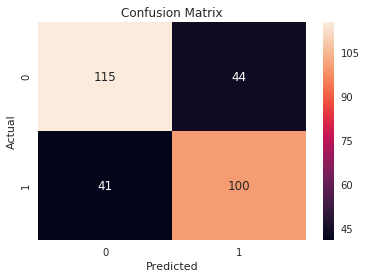

auc 0.7162451492038004
cv(10) auc 0.7129166916691669


In [150]:
X = df[feature_cols]
y = df.treatment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
lr=LogisticRegression()
lr.fit(X_train,y_train)
y_pred=lr.predict(X_test)
acc=accuracy_model_cv(lr, y_test, y_pred)

# GaussianNB

acc 0.7566666666666667


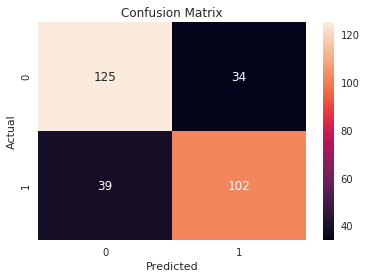

auc 0.7547838886658638
cv(10) auc 0.724897889788979


In [151]:
from sklearn.naive_bayes import GaussianNB
X = df[feature_cols]
y = df.treatment
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
gnb = GaussianNB()
y_pred = gnb.fit(X_train, y_train).predict(X_test)
acc=accuracy_model_cv(gnb, y_test, y_pred)

# LGBMClassifier

(559,) 280
train acc : 0.8407871198568873 ; test acc : 0.8652482269503546
testing test : 0.8533333333333334
acc 0.8533333333333334


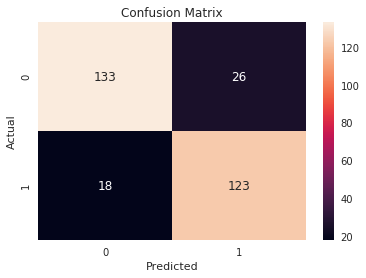

auc 0.8544092064766493
cv(10) auc 0.8289224922492249
(560,) 281
train acc : 0.8607142857142858 ; test acc : 0.8714285714285714
testing test : 0.8433333333333334
acc 0.8433333333333334


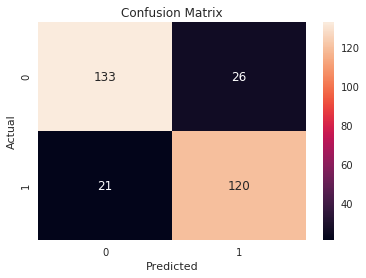

auc 0.8437709086043088
cv(10) auc 0.8289224922492249
(560,) 281
train acc : 0.8767857142857143 ; test acc : 0.7071428571428572
testing test : 0.8366666666666667
acc 0.8366666666666667


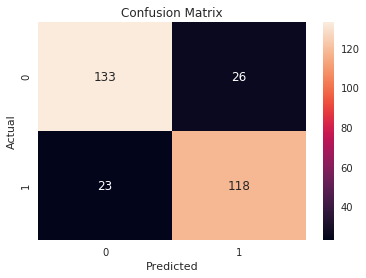

auc 0.8366787100227486
cv(10) auc 0.8289224922492249
(560,) 281
train acc : 0.8535714285714285 ; test acc : 0.8357142857142857
testing test : 0.8466666666666667
acc 0.8466666666666667


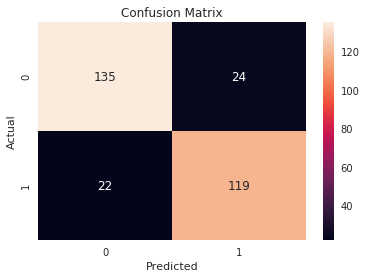

auc 0.8465141174896293
cv(10) auc 0.8289224922492249
(561,) 281
train acc : 0.8609625668449198 ; test acc : 0.8201438848920863
testing test : 0.8466666666666667
acc 0.8466666666666667


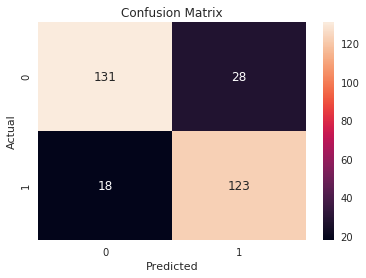

auc 0.8481198983005487
cv(10) auc 0.8289224922492249
0.8533333333333334 LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.00875, max_depth=20, metric='binary_logloss',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=215, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)


In [152]:
from sklearn.model_selection import StratifiedKFold
from sklearn.externals import joblib
from azureml.core import Experiment
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="treatment-model")
run = experiment.start_logging()
kfold=StratifiedKFold(5,shuffle=True)
p=[]
X = df[feature_cols]
y = df.treatment
m=[]
p=[]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)
for train_index, test_index in kfold.split(X_train, y_train):
    train_index,test_index=train_index[:],test_index[:]
    X_train1, X_test1 = X_train.iloc[train_index,:], X_train.iloc[test_index,:]
    y_train1, y_test1 = np.array(y_train)[train_index], np.array(y_train)[test_index]
    print(y_train1.shape,sum(y_train1))
#     clf=lgb.LGBMClassifier(learning_rate = hyp_opt_para["learning_rate"],
#         bagging_fraction = hyp_opt_para["bagging_fraction"],
#         feature_fraction = hyp_opt_para["feature_fraction"],
#         min_data_in_leaf = hyp_opt_para["min_data_in_leaf"],
#         min_gain_to_split = hyp_opt_para["min_gain_to_split"],
#         lambda_l1 = hyp_opt_para["lambda_l1"],
#         lambda_l2 = hyp_opt_para["lambda_l2"],                  
#         boosting_type = hyp_opt_para["boosting"],
#         objective = 'binary',
#         min_data_in_bin = hyp_opt_para["min_data_in_bin"],
#         metric = 'binary_logloss',
#         sub_feature = 0.5,
#         max_bin = hyp_opt_para["max_bin"],                   
#         num_leaves = hyp_opt_para["num_leaves"],
#         max_depth = hyp_opt_para["max_depth"])
    clf=lgb.LGBMClassifier(boosting='gbdt', boosting_type='gbdt', class_weight=None,
        colsample_bytree=1.0, importance_type='split',
        learning_rate=0.00875, max_depth=20, metric='binary_logloss',
        min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
        n_estimators=100, n_jobs=-1, num_leaves=215, objective=None,
        random_state=None, reg_alpha=0.0, reg_lambda=0.0, silent=True,
        subsample=1.0, subsample_for_bin=200000, subsample_freq=0)
    clf.fit(X_train1,y_train1)
    y_pred=clf.predict(X_test)
    print('train acc :',ac(clf.predict(X_train1),y_train1),'; test acc :',ac(clf.predict(X_test1),y_test1))
    print('testing test :',ac(clf.predict(X_test),y_test))
    acc = accuracy_model_cv(clf, y_test, y_pred)
    p.append(ac(clf.predict(X_test),y_test))
    m.append(clf)
best_index = p.index(max(p))
print(p[best_index], m[best_index])
model_name = "LGBMClassifier_" + str(p[best_index]) + ".pkl"
run.log("best acc Val:", p[best_index])
model_name = "LGBMClassifier_" + str(p[best_index]) + ".pkl"
filename = "outputs/" + model_name
joblib.dump(value=m[best_index], filename=filename)
run.upload_file(name=model_name, path_or_stream=filename)
run.complete()

In [153]:
# AZURE TIME
from azureml.core import Workspace, Run
ws = Workspace.from_config()
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_SKU", "STANDARD_D2_V2")


if compute_name in ws.compute_targets:
    compute_target = ws.compute_targets[compute_name]
    if compute_target and type(compute_target) is AmlCompute:
        print('found compute target. just use it. ' + compute_name)
else:
    print('creating a new compute target...')
    provisioning_config = AmlCompute.provisioning_configuration(vm_size=vm_size,
                                                                min_nodes=compute_min_nodes,
                                                                max_nodes=compute_max_nodes)

    # create the cluster
    compute_target = ComputeTarget.create(
        ws, compute_name, provisioning_config)

    # can poll for a minimum number of nodes and for a specific timeout.
    # if no min node count is provided it will use the scale settings for the cluster
    compute_target.wait_for_completion(
        show_output=True, min_node_count=None, timeout_in_minutes=20)

    # For a more detailed view of current AmlCompute status, use get_status()
    print(compute_target.get_status().serialize())

found compute target. just use it. cpucluster


In [154]:
# AZURE TIME
from azureml.core import Workspace, Run
ws = Workspace.from_config()

In [155]:
from azureml.core import Experiment
experiment = Experiment(workspace=ws, name="treatment-model")

In [156]:
from sklearn.externals import joblib

In [157]:
experiment

Name,Workspace,Report Page,Docs Page
treatment-model,data_,Link to Azure Portal,Link to Documentation


In [158]:
from azureml.core.model import Model
model = Model.register(model_path = "./outputs/LGBMClassifier_0.8533333333333334.pkl",
                       model_name = "LGBMClassifier.pkl",
                       tags = {'area': "health-treatment", 'type': "binaryClassification"},
                       workspace = ws)

Registering model LGBMClassifier.pkl


In [159]:
%%writefile score.py
from sklearn.externals import joblib
from azureml.core.model import Model
import json

def init():
    global model
    model_path = Model.get_model_path('LGBMClassifier_0.8533333333333334.pkl')
    # deserialize the model file back into a sklearn model
    model = joblib.load(model_path)
# note you can pass in multiple rows for scoring
def run(raw_data):
    try:
        print(1)
        data = json.loads(raw_data)['data']
        data = numpy.array(data)
        result = model.predict(data)
        # you can return any datatype if it is JSON-serializable
        return result.tolist()
    except Exception as e:
        error = str(e)
        return error

Overwriting score.py


In [160]:
from azureml.core.conda_dependencies import CondaDependencies 
myenv = CondaDependencies.create(conda_packages=['numpy','scikit-learn'])
with open("myenv.yml","w") as f:
    f.write(myenv.serialize_to_string())

In [161]:
from azureml.core import Image
from azureml.core import image
from azureml.core.image import ContainerImage
# configure the image
image_config = ContainerImage.image_configuration(execution_script="score.py",
                                                    runtime="python",
                                                    conda_file="myenv.yml",
                                                    )
# create the image
image = Image.create(name='myimg', models=[model], image_config=image_config, workspace=ws)

# wait for image creation to finish
image.wait_for_creation(show_output=True)

Creating image
Running...............................
Succeeded
Image creation operation finished for image myimg:6, operation "Succeeded"


In [162]:
from azureml.core.webservice import AciWebservice
aciconfig = AciWebservice.deploy_configuration(cpu_cores=1, 
                                               memory_gb=1, 
                                               tags={'area': "health-treatment", 'type': "binaryClassification"},
                                               description='LGBM Classifier')

In [163]:
import pickle
from sklearn.externals import joblib

clf = joblib.load(os.path.join(os.getcwd(), './outputs/LGBMClassifier_0.8533333333333334.pkl'))
y_hat = clf.predict(X_test)
print(y_hat)

[0 1 1 1 0 1 1 1 1 0 1 1 0 1 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1
 0 0 1 1 1 0 0 0 0 1 1 0 0 1 0 1 1 0 0 0 1 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0
 1 0 1 1 0 0 0 0 0 1 0 0 1 0 1 0 1 0 0 1 0 1 1 0 1 1 1 0 1 1 0 1 0 0 1 1 1
 0 1 1 0 1 0 1 0 0 0 0 1 0 1 0 1 1 1 0 1 1 1 0 0 1 0 1 1 0 0 1 0 1 1 1 1 0
 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 1 0 0 0 0 1 1 0 0 0 1 0 1
 1 0 0 0 0 1 0 0 1 0 0 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 1 1 1 1 0 1 1
 1 1 0 0 0 0 1 1 1 0 1 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1
 0 1 0 0 1 0 1 1 1 1 1 0 0 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 0 0 0 0 0 0
 1 0 0 1]


In [164]:
%%time
from azureml.core.webservice import Webservice
from azureml.core.model import InferenceConfig

inference_config = InferenceConfig(runtime= "python", 
                                   entry_script="score.py",
                                   conda_file="myenv.yml")

service = Model.deploy(workspace=ws, 
                       name='lgbm-classifier-svc',
                       models=[model], 
                       inference_config=inference_config,
                       deployment_config=aciconfig)
print(service.state)
service.wait_for_deployment(show_output=True)

ERROR - Error, there is already a service with name lgbm-classifier-svc found in workspace data_



WebserviceException: WebserviceException:
	Message: Error, there is already a service with name lgbm-classifier-svc found in workspace data_
	InnerException None
	ErrorResponse 
{
    "error": {
        "message": "Error, there is already a service with name lgbm-classifier-svc found in workspace data_"
    }
}

In [165]:
print(service.scoring_uri)

None
